In [1]:
import numpy as np
import matplotlib as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib import pyplot
import seaborn as sns
from scipy.stats import gaussian_kde
import pathlib
from matplotlib.colors import ListedColormap

In [2]:
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] ='serif'

pyplot.rcParams['xtick.direction'] = 'in'
pyplot.rcParams['xtick.minor.visible'] = True
pyplot.rcParams['ytick.direction'] = 'in'
pyplot.rcParams['ytick.minor.visible'] = True
pyplot.rcParams['xtick.major.size'] = 5
pyplot.rcParams['ytick.major.size'] = 5
pyplot.rcParams['ytick.right'] = True
pyplot.rcParams['xtick.top'] = True 

In [3]:
tmp_color = sns.cubehelix_palette(8, start=.5, rot=-.75, dark=0.2, light=.85)[0::3]
c_baryonic = tmp_color[:2]

In [4]:
plots_directory = '../plots/'

prior_directory = '../results/prior/'

including_adm_directory = '../results/posterior/NICER_Real_Data/NICER_REAL_ADM_VARYING_BARYONIC/'

neglecting_adm_directory = '../results/posterior/NICER_Real_Data/NICER_REAL_BARYONIC/'

In [5]:
colors = np.array(["#c6878f", "#b79d94", "#969696", "#67697c", "#233b57", "#BCBEC7"])

In [6]:
def calc_bands(x, y):
    miny = np.zeros((len(y),3))
    maxy = np.zeros((len(y),3))
    
    for i in range(len(y)):
        z = y[i][y[i]>0.0]
        if len(z)<200:
            print('sample too small for %.2f' %x[i])
            continue
        kde = gaussian_kde(z)
        testz = np.linspace(min(z),max(z), 1000)
        pdf = kde.pdf(testz)
        array = pdf
        index_68 = np.where(np.cumsum(np.sort(array)[::-1]) < sum(array)*0.6827)[0]
        index_68 = np.argsort(array)[::-1][index_68]
        index_95 = np.where(np.cumsum(np.sort(array)[::-1]) < sum(array)*0.95)[0]
        index_95 = np.argsort(array)[::-1][index_95]
        miny[i] =  x[i], min(testz[index_68]), min(testz[index_95])
        maxy[i] =  x[i], max(testz[index_68]), max(testz[index_95])
        
    miny = miny[~np.all(miny == 0, axis=1)]
    maxy = maxy[~np.all(maxy == 0, axis=1)]
    return miny, maxy


In [7]:
energydensities = np.logspace(14.2, 16, 50)
pressures_prior = np.load(prior_directory + 'FERMIONIC_REAL_DATA_PRIOR_Pressure_array.npy')
prior_contours = calc_bands(energydensities, pressures_prior)


maxpres_adm_NI = np.load(including_adm_directory + 'NICER_REAL_ADM_VARYING_BARYONIC_maxpres.npy')
minpres_adm_NI = np.load(including_adm_directory + 'NICER_REAL_ADM_VARYING_BARYONIC_minpres.npy')
adm_contours_NI = minpres_adm_NI,maxpres_adm_NI


sample too small for 6551285568595496.00
sample too small for 7129535313794352.00
sample too small for 7758824319047053.00
sample too small for 8443657568728348.00
sample too small for 9188937680019554.00
sample too small for 10000000000000000.00


In [8]:
contours_min = np.load(neglecting_adm_directory + 'NICER_REAL_BARYONIC_minpres.npy')
contours_max = np.load(neglecting_adm_directory + 'NICER_REAL_BARYONIC_maxpres.npy')
minpres_ppNI = np.log10(contours_min)
maxpres_ppNI = np.log10(contours_max)

In [9]:
def mass_radius_posterior_plot(root_name_ADM,root_name_Baryonic,root_prior = None,ax = None):
    pre_scatter_ADM = np.loadtxt(root_name_ADM + 'scattered.txt')
    scatter_ADM = []
    for i in range(len(pre_scatter_ADM)):
        if pre_scatter_ADM[i][3] >0. and pre_scatter_ADM[i][3] < 20.: #eliminating Halos (>0) and the few stars that were sampled of having radii larger than what NICER considers (>20)
            scatter_ADM.append([pre_scatter_ADM[i][2],pre_scatter_ADM[i][3]])
            
    scatter_ADM = np.array(scatter_ADM)

    
    kdeadm = sns.kdeplot(x = scatter_ADM[:,1], y = scatter_ADM[:,0], gridsize=40, 
               fill=False, ax=ax, levels=[0.05,0.32,1.],bw_adjust = 1.5,
                alpha=1., colors = '#E76F51',linestyles = '-.',linewidths = 3.)
    
    p = kdeadm.collections[0].get_paths()[0]
    v = p.vertices
    ly_95 = max([v[r][1] for r in range(len(v))])
    
    p = kdeadm.collections[1].get_paths()[0]
    v = p.vertices
    ly_68 = max([v[r][1] for r in range(len(v))])
    
    
    print('68% Max mass Including ADM: ',ly_68)
    print('95% Max mass Including ADM: ',ly_95)

    if root_prior is not None:
        scatter_prior = np.loadtxt(root_prior + 'scattered.txt')


    
        sns.kdeplot(x = scatter_prior[:,6], y = scatter_prior[:,5], gridsize=40, 
                   fill=False, ax=ax, levels=[0.05],bw_adjust = 1.5,
                    alpha=1., colors = 'black',linestyles = '--',linewidths = 3.)

    MR_prpr_B= np.loadtxt(root_name_Baryonic + 'MR_prpr.txt')
    


    kdeb = sns.kdeplot(x = MR_prpr_B[:,1], y = MR_prpr_B[:,0], gridsize=40,bw_adjust = 1.5, 
                fill=True, ax=ax, levels=[0.05,0.32,1.],
                alpha=1., cmap=ListedColormap(c_baryonic))
    
    
    
    ax.set_xlim(9, 15)
    ax.set_xticks([10,11,12,13,14,15])
    ax.set_ylim(1., 2.7)
    ax.set_yticks([1.,1.4,1.8,2.2,2.7])
    
    ax.minorticks_on()
    ax.tick_params(top=1,right=1, which='both', direction='in', labelsize=20)
    ax.set_xlabel(r'Radius [km]', fontsize=20)
    ax.set_ylabel(r'Mass [M$_{\odot}$]', fontsize=20)
    



In [10]:
root_name_ADM = including_adm_directory + 'NICER_REAL_ADM_VARYING_BARYONIC_'
root_name_B = neglecting_adm_directory + 'NICER_REAL_BARYONIC_'
root_prior = prior_directory + 'FERMIONIC_REAL_DATA_PRIOR_'

68% Max mass Including ADM:  2.2981016668383285
95% Max mass Including ADM:  2.581759262006436


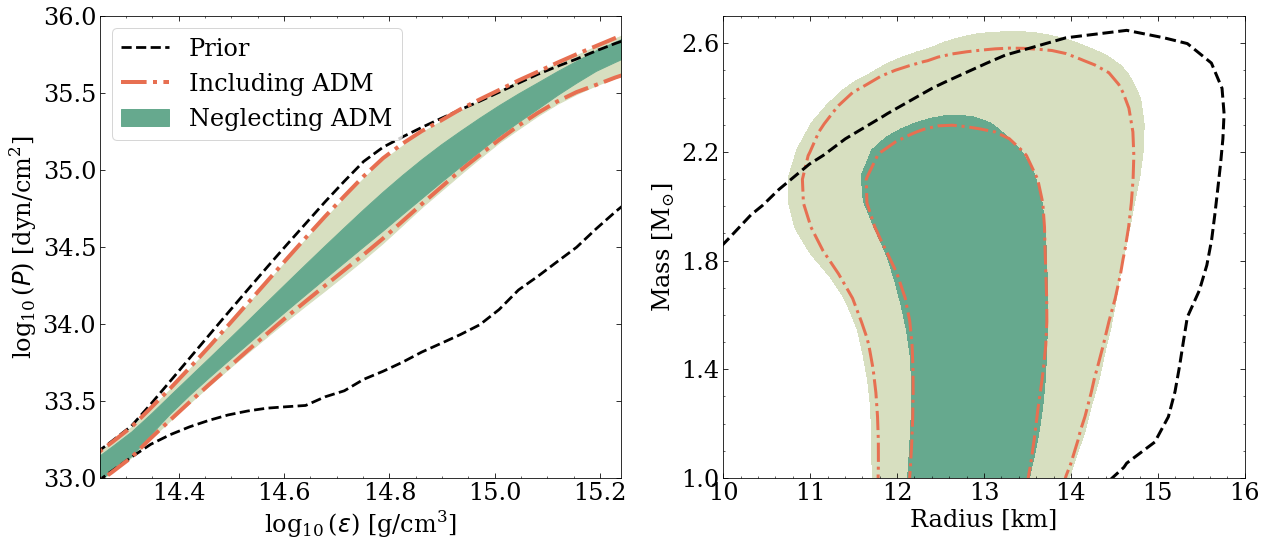

In [11]:
fig, ax = pyplot.subplots(nrows=1, ncols=2,figsize=(18,8))
my_fontsize=24
my_font = 'serif'
plt.rc('font',family = my_font)
plt.rcParams.update({'font.size': 20})

mass_radius_posterior_plot(root_name_ADM,root_name_B,root_prior,ax = ax[1])




adm_contours_min = adm_contours_NI[0]
adm_contours_max = adm_contours_NI[1]
minpres_adm = np.log10(adm_contours_min)
maxpres_adm = np.log10(adm_contours_max)


prior_contours_min = prior_contours[0]
prior_contours_max = prior_contours[1]
minpres_prior = np.log10(prior_contours_min)
maxpres_prior = np.log10(prior_contours_max)




ax[0].plot(maxpres_prior[:,0], minpres_prior[:,2], c='black', linestyle='--', lw=2.75)
ax[0].plot(maxpres_prior[:,0], maxpres_prior[:,2], c='black', linestyle='--', lw=2.75,label = 'Prior')

ax[0].plot(maxpres_adm[:,0], minpres_adm[:,2], c='#E76F51', linestyle='-.', lw=4)
ax[0].plot(maxpres_adm[:,0], maxpres_adm[:,2], c='#E76F51', linestyle='-.', lw=4,label = 'Including ADM')
ax[0].fill_between(minpres_ppNI[:,0], minpres_ppNI[:,2], maxpres_ppNI[:,2], 
                       color=sns.cubehelix_palette(8, start=.5, rot=-.75, dark=.2, light=.85)[0], alpha=1)
ax[0].fill_between(minpres_ppNI[:,0], minpres_ppNI[:,1], maxpres_ppNI[:,1], 
                       color=sns.cubehelix_palette(8, start=.5, rot=-.75, dark=.2, light=.85)[3], 
                      alpha=1,label = 'Neglecting ADM')
       

ax[0].set_ylabel(r'$\log_{10}(P)$ [dyn/cm$^2$]', size=my_fontsize,font = my_font)



ax[0].legend(loc = 'upper left',fontsize = 24)
ax[0].set_xlim(14.25, 15.24)
ax[0].set_xlabel(r'$\log_{10}(\varepsilon)$ [g/cm$^3$]', fontsize=my_fontsize,font = my_font)
ax[0].set_xticks(np.arange(14.25, 15.24,.05),minor =True)
ax[0].set_ylim(33,36)
ax[0].set_yticks([33,33.5,34,34.5,35,35.5,36],minor =True)
ax[0].tick_params(top=1,right=1, which='both', direction='in', labelsize=my_fontsize)

ax[1].set_xlim(10, 16)
ax[1].set_xticks([10,11,12,13,14,15,16])
ax[1].set_ylim(1., 2.7)
ax[1].set_yticks([1.,1.4,1.8,2.2,2.6])

ax[1].minorticks_on()
ax[1].tick_params(top=1,right=1, which='both', direction='in', labelsize=my_fontsize)
ax[1].set_xlabel(r'Radius [km]', fontsize=my_fontsize)
ax[1].set_ylabel(r'Mass [M$_{\odot}$]', fontsize=my_fontsize)
    
    

pyplot.tight_layout()
pyplot.show()
fig.savefig(plots_directory + 'Real_data_posterior.png',bbox_inches='tight')



## We needed to re-insert the sns contours for the Neglecting ADM contours here since the above code will print the Including ADM bands. Also note, that we needed to use sns.kde intervals over the corner quantiles (or equivalently get_quantiles function) because of the bw_adjust and gridsize arguments, which modify the 95% & 68% contours slightly.

68% Max mass Neglecting ADM:  2.334399574285514
95% Max mass Neglecting ADM:  2.6427855223715464


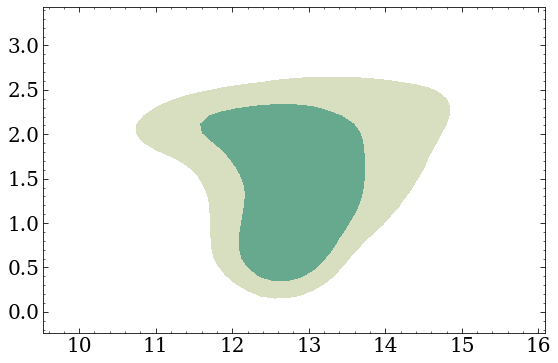

In [13]:
#Baryonic (Neglecting ADM)
root_name_B = neglecting_adm_directory + 'NICER_REAL_BARYONIC_'
MR_prpr_B= np.loadtxt(root_name_B + 'MR_prpr.txt')
figure, ax = pyplot.subplots(1,1, figsize=(9,6))
kdeb = sns.kdeplot(x = MR_prpr_B[:,1], y = MR_prpr_B[:,0], gridsize=40,bw_adjust = 1.5, 
            fill=True, ax=ax, levels=[0.05,0.32,1.],
                alpha=1., cmap=ListedColormap(c_baryonic))
    
pb = kdeb.collections[0].get_paths()[0]
vb = pb.vertices
ly_95 = max([vb[r][1] for r in range(len(vb))])
    
pb = kdeb.collections[1].get_paths()[0]
vb = pb.vertices
ly_68 = max([vb[r][1] for r in range(len(vb))])
    
    
print('68% Max mass Neglecting ADM: ',ly_68)
print('95% Max mass Neglecting ADM: ',ly_95)

In [14]:
import corner as corner
pressure_NICER_ADM = np.load(including_adm_directory + 'NICER_REAL_ADM_VARYING_BARYONIC_pressures.npy')



pressure_NICER_no_ADM = np.load(neglecting_adm_directory + 'NICER_REAL_BARYONIC_pressures.npy')

In [15]:
j = 5
k = 22
energydensities = np.logspace(14.2, 16, 50)
print(np.log10(energydensities[j]))

print(np.log10(energydensities[k]))


14.383673469387755
15.008163265306122


In [16]:
ADM = corner.quantile(pressure_NICER_ADM[j], (0.05,0.5,0.95), weights=None)

W_ADM = ADM[2]-ADM[0]


noADM = corner.quantile(pressure_NICER_no_ADM[j], (0.05,0.5,0.95), weights=None)

W_noADM = noADM[2]-noADM[0]

print('95% Confidence Including ADM: ', ADM)
      
print('95% Confidence Neglecting ADM: ', noADM)

Percent_change_ADM = ((W_ADM-W_noADM)/W_noADM)*100

print('Percent diff: ', Percent_change_ADM)

95% Confidence Including ADM:  [2.49904622e+33 3.07138784e+33 3.74798206e+33]
95% Confidence Neglecting ADM:  [2.47624381e+33 3.04955632e+33 3.71554581e+33]
Percent diff:  0.777359892128086


In [17]:
ADM = corner.quantile(pressure_NICER_ADM[k], (0.05,0.5,0.95), weights=None)

W_ADM = ADM[2]-ADM[0]


noADM = corner.quantile(pressure_NICER_no_ADM[k], (0.05,0.5,0.95), weights=None)

W_noADM = noADM[2]-noADM[0]

print('95% Confidence Including ADM: ', ADM)
      
print('95% Confidence Neglecting ADM: ', noADM)

Percent_change_ADM = ((W_ADM-W_noADM)/W_noADM)*100

print('Percent diff: ', Percent_change_ADM)

95% Confidence Including ADM:  [0.00000000e+00 2.04793224e+35 3.14854018e+35]
95% Confidence Neglecting ADM:  [0.00000000e+00 2.00172744e+35 3.13074044e+35]
Percent diff:  0.5685472110333274
